# 3.2 Contrastive Learning

In this part of the tutorial we will be looking at contrastive learning. The 

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from tqdm import tqdm
from typing import Tuple
import random as rd

torch.manual_seed(0);

In [2]:
class PairedDigits(Dataset):
    def __init__(self):
        digits, labels = load_digits(return_X_y=True)
        self.digits = (torch.from_numpy(digits) / 16.).float()
        self.labels = torch.from_numpy(labels).long()
        
    def __len__(self):
        return len(self.digits)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        image, label = self.digits[idx], self.labels[idx]
        similarity_label = rd.random() > .5
        if similarity_label:
            other_indices = self.labels == label
        else:
            other_indices = self.labels != label
        other = self.digits[rd.choice(other_indices.nonzero()[0])]
        return image, other, similarity_label * 1.

dataset = PairedDigits()
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [3]:
class ContrastiveModel(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(8 * 8, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        
    def forward(self, image: torch.Tensor, other: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        return (
            self.encoder(image),
            self.encoder(other)
        )

In [4]:
def contrastive_loss(x1: torch.Tensor, x2: torch.Tensor, y: torch.Tensor, m: float = 1.) -> torch.Tensor:
    h = torch.linalg.norm(x1 - x2, dim=1)
    loss = y * h / 2 + (1 - y) * torch.clamp(m - h, min=0) / 2
    return loss.mean()

In [5]:
model = ContrastiveModel()
optimizer = torch.optim.Adam(params=model.parameters())

In [6]:
loss_fn = nn.CosineEmbeddingLoss()

In [7]:
for epoch in range(100):
    model.train()
    total_loss = 0.
    for X1, X2, y in dataloader:
        X1, X2 = X1.flatten(1), X2.flatten(1)
        
        optimizer.zero_grad()
        y1, y2 = model(X1, X2)
        loss = contrastive_loss(y1, y2, y)
        # loss = loss_fn(y1, y2, y*2-1)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {total_loss/len(dataloader):.4f}")

Epoch 0 | Loss: 0.2224
Epoch 10 | Loss: 0.0101
Epoch 20 | Loss: 0.0050
Epoch 30 | Loss: 0.0035
Epoch 40 | Loss: 0.0028
Epoch 50 | Loss: 0.0021
Epoch 60 | Loss: 0.0016
Epoch 70 | Loss: 0.0009
Epoch 80 | Loss: 0.0007
Epoch 90 | Loss: 0.0005


# Is anything wrong until here?

In [8]:
mnist_dataloader = DataLoader(TensorDataset(dataset.digits, dataset.labels), batch_size=100)
with torch.inference_mode():
    predictions, labels = zip(*[(model.encoder(X.flatten(1)), y) for X, y in mnist_dataloader])
    predictions = torch.cat(predictions)
    labels = torch.cat(labels)

In [9]:
predictions.shape

torch.Size([1797, 2])

<Axes: xlabel='None', ylabel='None'>

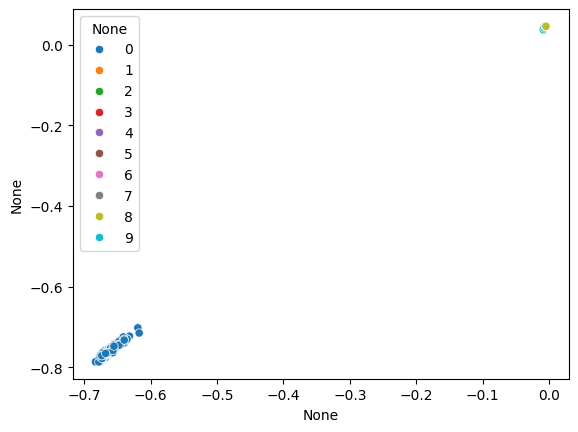

In [10]:
sns.scatterplot(x=predictions[:, 0], y=predictions[:, 1], hue=labels, palette='tab10')

In [11]:
from sklearn.cluster import KMeans

In [12]:
kmeans = KMeans(10)

In [13]:
kmeans.fit(predictions.numpy())

KMeans(n_clusters=10)

In [16]:
kmeans.inertia_

0.6686120629310608

In [17]:
from sklearn.metrics import rand_score

In [18]:
preds = kmeans.predict(predictions.numpy())
preds

array([4, 8, 8, ..., 8, 6, 8], dtype=int32)

In [19]:
import numpy as np
np.unique(preds, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 16, 870,  23,  24,  46,  36, 138,  13, 589,  42]))

In [20]:
rand_score(preds, labels)

0.648419848473018

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
knn = KNeighborsClassifier()
knn.fit(predictions.numpy(), labels)

KNeighborsClassifier()

In [23]:
knn.score(predictions.numpy(), labels)

0.5442404006677797

In [24]:
from sklearn.metrics.cluster import contingency_matrix

In [25]:
predictions.shape, labels.shape

(torch.Size([1797, 2]), torch.Size([1797]))

In [26]:
contingency_matrix(preds, labels)

array([[ 16,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  27,  54,  98, 103, 129,  99, 142, 102, 116],
       [ 23,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   1,   1,   4,   0,   8,   0,   0,   8],
       [ 46,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 36,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   5,   3,   2,  24,  20,  12,  12,  14,  45],
       [ 12,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 150, 119,  82,  49,  33,  62,  25,  58,  11],
       [ 42,   0,   0,   0,   0,   0,   0,   0,   0,   0]])